# Designing a Linear Regression Model to Appreciate all Those Math Classes

This should be fun; I am most interested in how these models find the minimum error, which varies from model to model. Using my own models (hopefully a multilinear then logistic model to follow) I can test the rate at which different minimizing algorithms find solutions. 

## Introduction
To begin, let's get a test dataset together. I stole it from [this Kaggle page](https://www.kaggle.com/datasets/jayaantanaath/student-habits-vs-academic-performance?resource=download). 

In [1]:
## prereqs
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
## peek at the data
from os import getcwd
filepath = f"{getcwd()}\\stuData.csv"
stu_df = pd.read_csv(filepath)
stu_df.head(3)

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3


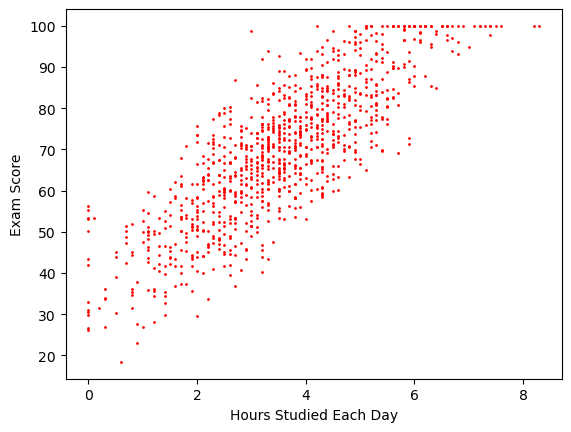

In [3]:
## looking for a linear correlation
## From my time as a teacher, I suspsect study hours and score to be linearly related
fig, ax = plt.subplots()
ax.set_ylabel("Exam Score")
ax.set_xlabel("Hours Studied Each Day")
ax.plot(
    stu_df.study_hours_per_day, 
    stu_df.exam_score, 
    'ro', markersize = 1.0
)
plt.show()

As suspected, we get a fairly linear correlation with reasonable noise. It should be a fine example to begin making a linear correlation model with.

In the context of the example, our predictor is a straight line. This means the model is very simple. For a given number of hours studied, the model returns their expected exam grade. An example of this is shown below, with me just kinda eyeballing it.

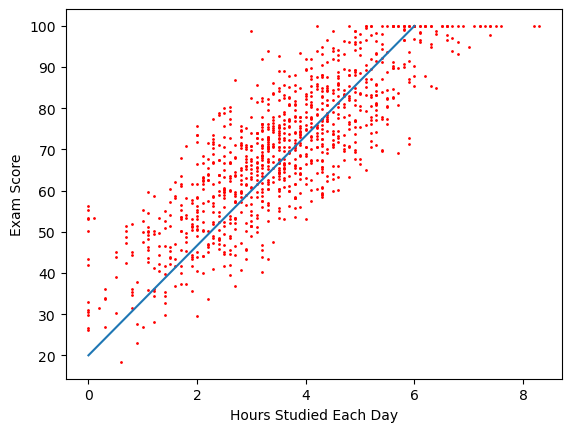

In [4]:
fig, ax = plt.subplots()
ax.set_ylabel("Exam Score")
ax.set_xlabel("Hours Studied Each Day")
ax.plot(
    stu_df.study_hours_per_day, 
    stu_df.exam_score, 
    'ro', markersize = 1.0
)
elis_guess = ([0, 6], [20, 100])
ax.plot(elis_guess[0], elis_guess[1])
plt.show()

The goal is to create a line with the minimal amount of error between the training data and the guesses. Since our model is represented by the standard linear equation $y = mx + b$, we need only select a value for $m$ and $b$ that generate predictions. These might seem like two random values, but the choices for $m$ and $b$ are deeply related as the coefficients of the variables $x^1$ and and $x^0$. That is, $y = mx + b = mx^1 + bx^0$. Thinking of the coefficients like this now will help us jump to higher-dimension regression later. 

We'll demonstrate the relatedness of $m$ and $b$ by placing them in a column vector (often referred to as $\hat \beta$): $\begin{bmatrix} m \\ b \end{bmatrix}$. Now we can plot all the values of $\hat \beta$ against its error, and determine the best choice for $m$ and $b$ by simply picking the ordered pair at the minimum. 

This is my favorite way of visualizing models since it's so inherently geometric. We'll essentially be looking at a wide mesh, with peaks and valleys. The location of the deepest valley is the ordered pair $(m, b, \text{Min Error})$, and so is the natrual best choice.

## Model Design

In [5]:
## I chose to avoid the classes approach in observance of a talk I recently attended
##  which made an interesting case against object-oriented programming.
##  I hope this is not any more confusing!

def gri_linModel(data, pair):
    return pair[0]*data + pair[1]

def gri_Err(targ, pred):
    return np.mean(np.abs(targ - pred))

def gri_MSE(targ, pred):
    targ = (targ - pred)**2
    return np.mean(targ)


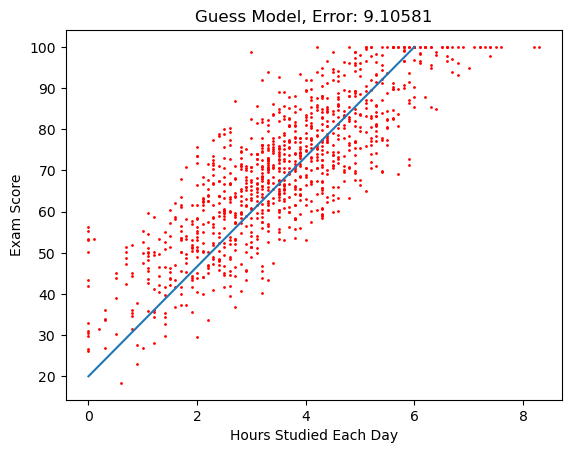

In [6]:
## guess model from earlier
## checking that the code is working

elis_model = ( 13.3, 20 )
elis_preds = gri_linModel( stu_df.study_hours_per_day, elis_model )
elis_model_err = gri_Err( stu_df.exam_score, elis_preds) 

fig, ax = plt.subplots()
ax.set_title(f"Guess Model, Error: {elis_model_err}")
ax.set_ylabel("Exam Score")
ax.set_xlabel("Hours Studied Each Day")
ax.plot(
    stu_df.study_hours_per_day, 
    stu_df.exam_score, 
    'ro', markersize = 1.0
)
elis_guess = ([0, 6], [20, 100])
ax.plot(elis_guess[0], elis_guess[1])
plt.show()

Above is my random guess I made ealier, with its error shown. Below, I plotted my guess against the minimum selected by the computer. The current method hasn't used any method of finding the minimum, we just plotted every possible ordered pair (since we had to anyways to make the graph). 

Below, the blue point on the surface is my random guess (faily close to the middle, and lying in the valley of the surface). I give myself about a 9.5/10. You can see in the skew of the lines that I (blue) selected my line neglecting that the maximum score was 100. The computer (red) isn't affected by this, and finds an even better solution!

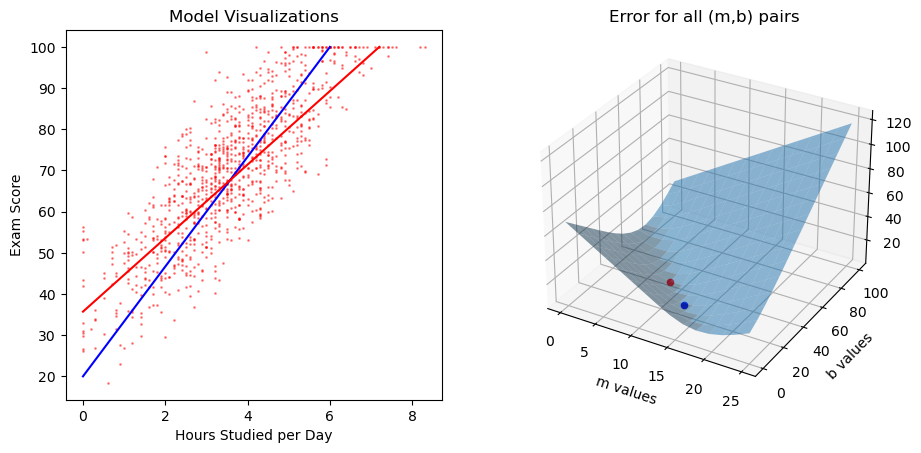

In [7]:
# Finding the best model

## Make an array of all possible (m, b) pairs. 
### Doing this is very computationally slow ... but worth it for the demonstration
density = 15
m = np.linspace(0, 25, density)  ## choice for m cannot be 0 or over say 25
b = np.linspace(0, 100, density) ## choice for b cannot be less than 0 or more than 100
m, b = np.meshgrid(m, b)         ## create mesh to plot with
z = np.zeros((density, density))

for i in range(0, density):
    for j in range(0, density):
        z[i, j] = gri_Err(
            targ = stu_df.exam_score,
            pred = gri_linModel(
                data = stu_df.study_hours_per_day,
                pair = (m[i,j], b[i,j])
            )
        )

## new figure object
fig, ax = plt.subplots(1, 2, figsize = plt.figaspect(0.45))

## remove one of the 2d figures, to be replaced with a 3d figure
ax[1].remove()
ax[1] = fig.add_subplot(1, 2, 2, projection = '3d')

## make a surface to plot on
surf = ax[1].plot_surface(m, b, z, alpha = 0.5)
ax[1].scatter(13.3, 20, elis_model_err, color = 'blue')

## finding the minimum
best_score = np.min(z)
best_model = ( m[ np.where(z == best_score) ], b[ np.where(z == best_score) ] )
ax[1].scatter( best_model[0][0], best_model[1][0], best_score, color = 'red')

ax[1].set_title("Error for all (m,b) pairs")
ax[1].set_xlabel("m values")
ax[1].set_ylabel("b values")

### second, 2d plot

ax[0].plot(stu_df.study_hours_per_day, stu_df.exam_score, 'ro', markersize = 1, alpha = 0.4)
ax[0].plot([0, 6], [20, 100], color = 'blue')
ax[0].plot(
    [0, (100-best_model[1][0])/best_model[0][0]], 
    [gri_linModel(0, best_model), [100]], 
    color = 'red'
)

ax[0].set_title("Model Visualizations")
ax[0].set_xlabel("Hours Studied per Day")
ax[0].set_ylabel("Exam Score")

plt.show()

In practice, there are typically way more predictors than just one. Even in this data set, to make this equation we neglected 90% of the available data. All that information can increase the accuracy of our scores. That means finding the minimum by generating every possible solution is slow, costly and frankly quite bad. 

To get around this, we need a method that can find the minimum. This is the "learning" of the model, in practice -- and there's many ways to it. I am most excited to demonstrate these various methods. 

# Method 1: Local Resolution

This method is a fairly naiive idea, but often works. Its success is dependent on the complexity of the function (loosely correlated with function degree). 

Numerically, this method converges really quickly, but isn't super accurate. With lower-degree regression, it should be fine. 

HIT at:  6
7.794316472119093 7.796073336458207 -0.0017568643391134842 3.0865723060486594e-06


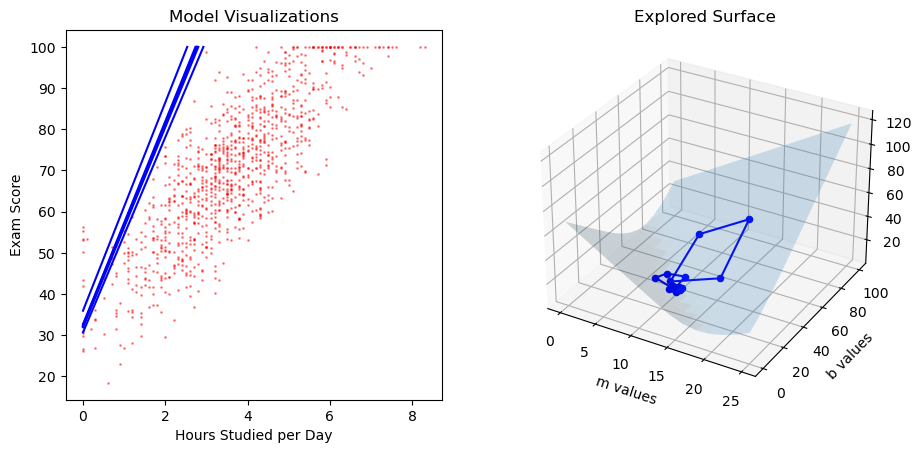

In [8]:
#%%time
## ============================
## creating a plot to visualize
## ============================

density = 15
m = np.linspace(0, 25, density)  ## choice for m cannot be 0 or over say 25
b = np.linspace(0, 100, density) ## choice for b cannot be less than 0 or more than 100
m, b = np.meshgrid(m, b)         ## create mesh to plot with
z = np.zeros((density, density))

for i in range(0, density):
    for j in range(0, density):
        z[i, j] = gri_Err(
            targ = stu_df.exam_score,
            pred = gri_linModel(
                data = stu_df.study_hours_per_day,
                pair = (m[i,j], b[i,j])
            )
        )

## new figure object
fig, ax = plt.subplots(1, 2, figsize = plt.figaspect(0.45))

## remove one of the 2d figures, to be replaced with a 3d figure
ax[1].remove()
ax[1] = fig.add_subplot(1, 2, 2, projection = '3d')

## make a surface to plot on
surf = ax[1].plot_surface(m, b, z, alpha = 0.2)

ax[1].set_title("Explored Surface")
ax[1].set_xlabel("m values")
ax[1].set_ylabel("b values")

### second, 2d plot

ax[0].plot(stu_df.study_hours_per_day, stu_df.exam_score, 'ro', markersize = 1, alpha = 0.4)

ax[0].set_title("Model Visualizations")
ax[0].set_xlabel("Hours Studied per Day")
ax[0].set_ylabel("Exam Score")

## =======================================
## loop setup 
## =======================================

mlim = np.array((0, 25)) ## initial target area -- can be guessed using other methods
blim = np.array((0, 100)) 
acc_targ = 1e-5

delta = np.array([max(mlim)-min(mlim), max(blim)-min(blim)])

xhat = np.array(( (mlim[0] + mlim[1])/2, (blim[0] + blim[1])/2 ))
n = 2
zhat1 = np.inf
zhat2 = np.inf


## ======================================
## loop execution 
## ======================================

MAXIT = 10
for iteration_number in range(0, MAXIT):
    dist = (3/8)**n
    dist_rect = np.array(
        [
            [dist, dist],
            [dist, -dist],
            [-dist, -dist],
            [-dist, dist]
        ]
    )
    xhat_rect = xhat + delta*dist_rect
    zval  = 0
    errs = np.zeros((1, 4))
    zhat1 = np.inf
    
    ## test each corner, use the corner with the minimum as the new center
    for k in range(0, 4):
        model_preds = gri_linModel(stu_df.study_hours_per_day, xhat_rect[k])
        current_error = gri_Err(stu_df.exam_score, model_preds)
        ax[1].scatter(xhat_rect[k][0], xhat_rect[k][1], current_error, color = 'blue')
        errs[0][k] = current_error
    
        if current_error < zhat1:
            zhat1 = current_error
            zval = k
    
    ## making our square region using lines
    ax[1].plot(
        np.concatenate((xhat_rect[:,0], [xhat_rect[0,0]] )),
        np.concatenate((xhat_rect[:,1], [xhat_rect[0,1]] )),
        np.concatenate((errs[0], [errs[0][0]])),
        color = 'blue',
        zorder = 1
    )
    
    ## making lines on the left-side plot
    ax[0].plot(
    [0, (100-xhat_rect[zval][0])/xhat_rect[zval][1]], 
    [gri_linModel(0, tuple(xhat_rect[zval])), 100], 
    color = 'blue'
    )
    
    xi = (zhat1 - zhat2)**2
    if xi < acc_targ:
        print("HIT at: ", iteration_number)
        print(zhat1, zhat2, zhat1-zhat2, (zhat1-zhat2)**2)
        break
    
    n = n + 1
    zhat2 = zhat1
    xhat = xhat_rect[zval]

plt.show()